In [1]:
# dash for layout
import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go
from dash.dependencies import State, Input, Output
from dash.exceptions import PreventUpdate
import io
from flask import Flask, request, render_template, redirect, url_for, send_file
import plotly
import pandas as pd
import numpy as np
from random import random
from bs4 import BeautifulSoup
import requests
import plotly.express as px
# Plotly function to generate table plot
 
def table_creater(df):
    df = df.dropna(subset=['Country'])
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df.columns),
                    line_color='rgb(60,60,60)',
                    fill_color='rgb(40,40,40)',
                    align='left',font=dict(color='white', size=17)),
        cells=dict(values=df.T.values,
                   fill_color='rgb(20,10,30)',
                   line_color='rgb(20,10,30)',
                   align='left',font=dict(color='white', size=14)))
    ])
    fig.update_layout(
        autosize=False,
        margin=dict(l=0,r=0,b=0,t=0,pad=0),
        paper_bgcolor='rgb(20,10,30)',
    )
    return(fig.data,fig.layout)
##################################################################################
def get_corona_data():
    url="https://www.worldometers.info/coronavirus/"
    # Make a GET request to fetch the raw HTML content
    html_content = requests.get(url).text
    # Parse the html content
    soup = BeautifulSoup(html_content, "lxml")
    gdp_table = soup.find("table", id = "main_table_countries_today")
    gdp_table_data = gdp_table.tbody.find_all("tr")

    # Getting all countries names
    dicts = {}
    for i in range(len(gdp_table_data)):
        try:
            key = (gdp_table_data[i].find_all('a', href=True)[0].string)
        except:
            key = (gdp_table_data[i].find_all('td')[0].string)

        value = [j.string for j in gdp_table_data[i].find_all('td')]
        dicts[key] = value
    live_data= pd.DataFrame(dicts).drop(0).T
    live_data.columns = ["Total Cases","New Cases", "Total Deaths", "New Deaths", "Total Recovered","Active","Serious Critical",
"Tot Cases/1M pop"]
    live_data.index.name = 'Country'
    live_data.iloc[:,:5].to_csv("input_data/base_data.csv")
################################################################################################
def horigental_plots(df):
    df['Active cases'] = df['Total Cases']- (df.iloc[:,2:].sum(1))
    df = df.drop('Total Cases',1)
    big_df = pd.DataFrame(columns= ['Country',"Total Cases","Type"])
    for i in df.columns[1:]:
        small_df = df[["Country",i]].rename(columns = {i:"Total Cases"}).reset_index(drop=True)
        small_df["Type"] = i
        big_df = big_df.append(small_df)
        fig = px.bar(big_df, x="Total Cases", y="Country", color='Type', orientation='h',
                     title='Current count',opacity=.9,text="Total Cases")

        fig.layout.yaxis.showtickprefix = 'first'
        fig.update_layout(plot_bgcolor='rgb(20,10,30)',
                 paper_bgcolor='rgb(20,10,30)',
                 font=dict(family="Courier New, monospace",
                           color="white"),margin= dict(t=0,r=0,b=40,l=40),legend = dict(x=.5,y=1),
                  width=500,height=300)
        fig.update_yaxes(ticks="inside",tickangle = -55)
    
    
    return(fig.data,fig.layout)

In [11]:
app = dash.Dash()  
def build_upper_left_panel():
    return html.Div(
        id="upper-left",
        className="six columns",
        children=[
            html.P(
                id="section-title",
                children="SPREAD RATE OF CORONA AROUND THE WORLD LIVE",
            ),
            html.Div(
                className="control-row-1",
                children=[
                    html.Div(
                        id="state-select-outer",
                        children=[
                            html.Div([
                            dcc.Interval(
                                id='interval-component-2',
                                interval=10*1000, # in milliseconds
                                n_intervals=0
                            ),
                            dcc.Interval(
                                id='interval-component-1',
                                interval=60*1000, # in milliseconds
                                n_intervals=0
                            )
                                
                        ]),
                        html.Div(id="loading-outer-frame1",
                                 children=[]),
                            html.Div(dcc.Loading(
                                    id="loading3",
                                    children=dcc.Graph(
                                        id='graph3',
                                        figure={
                                            "data": [],
                                            "layout": []
                                        },
                                    style={'width':'400%','hight':'400','margin':'0%'}),
                                ),
                        )
                        ]
                    ),
                ],
            )],
    style={'width':'50%','hight':'120%','margin':'0%','display':'inline-block'})
#################################################################################################################
app.layout = html.Div(
    className="container scalable",
    children=[
        html.Div(
            id="banner",
            className="banner",
            children=[
                html.H6("CORONAVIRUS EPIDEMIC CASES AROUND THE WORLD LIVE COUNT AND ANALYSIS")
            ],style={'color': 'white', 'fontSize': 100,'font-family' :'Arial Black'}
        ),
        html.Div(
            id="upper-container",
            className="row",
            children=[
                build_upper_left_panel(),
                html.Div(
                    id="geo-map-outer",
                    className="six columns",
                    children=[
                        html.P(
                            id="map-title",
                            children="CONFIRMED CASES AND DEATHS BY COUNTRY UPDATED EVERY 10 SECONDS",
                        ),
                        html.Div(
                            id="loading-outer-frame",
                            children=[
                                dcc.Loading(
                                    id="loading",
                                    children=dcc.Graph(
                                        id='graph1',
                                        figure={
                                            "data": [],
                                            "layout": []
                                        },
                                    style={'width':'100%','hight':'100%','margin':'0%'}),
                                )
                            ],
                        ),
                    ]
                , style={'width':'46%','hight':'120%','margin':'0%','display':'inline-block','animation-name': 'example',
  'animation-duration': '10s','animation-iteration-count': 'infinite'}),
            ],
        )
    ],
style={'width':'100%','hight':'120%','margin':'0%'})

## Callback function to generate take input on dropdown and update the child checklist 

@app.callback(
    [Output('graph1', "figure"),
    Output('graph3', "figure"),
    Output("loading-outer-frame1", "children")],
    [Input('interval-component-2', 'n_intervals')],
)

def update_region_dropdown(state_select):
    df = pd.read_csv("input_data/base_data.csv")
    df = df.loc[np.unique(np.random.randint(0,df.shape[0],(40)))]
    for i in df.columns[1:]:
        try:
            df[i] = df[i].apply(lambda x : x.replace(",","").replace(" ","") if (type(x)==str) else '0')
            df[i] = df[i].apply(lambda x : int(x) if len(x)>0 else 0)
        except:
            df[i] = df[i].apply(lambda x : int(x) if len(x)>0 else 0)
        df = df.sort_values('Total Cases',ascending =False)
    traces,layouts=table_creater(df)
    traces_hori1,layouts_hori2=horigental_plots(df.iloc[:8,:])
    return (
       [{
        'data':traces,
        'layout':layouts
        }
       ,
       {
        'data':traces_hori1,
        'layout':layouts_hori2
        },
       html.Video(src='/static/2_5_1.webm',controls=True,autoPlay=True,loop=True,width="220%",height='400%')]
      )
########################################################################################
@app.callback([Output('section-title', "children")],
    [Input('interval-component-1', 'n_intervals')]
    )

def download_data(state_select):
    get_corona_data()
    df = pd.read_csv("input_data/base_data.csv",index_col=[0])
    for i in df.columns:
        try:
            df[i] = df[i].apply(lambda x : x.replace(",","").replace(" ","") if (type(x)==str) else '0')
            df[i] = df[i].apply(lambda x : int(x) if len(x)>0 else 0)
        except:
            df[i] = df[i].apply(lambda x : int(x) if len(x)>0 else 0)
    cc =df.sum()

    return (
       ["TOTAL CASES- {}, NEW CASES- {}      ......      TOTAL DEATHS- {},  NEW DEATHS-{}      ......        TOTAL RECOVERED-{}".format(cc[0],cc[1],cc[2],cc[3],cc[4])])

if __name__=='__main__':
    app.run_server()  
  

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [20/Mar/2020 17:28:50] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:28:50] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:28:50] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:28:50] "GET /_favicon.ico?v=1.9.1 HTTP/1.1" 200 -
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

127.0.0.1 - - [20/Mar/2020 17:28:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:28:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:28:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:28:55] "GET /

127.0.0.1 - - [20/Mar/2020 17:38:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:38:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:38:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:38:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:39:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:39:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:39:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:39:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:39:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:39:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:39:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:40:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.

127.0.0.1 - - [20/Mar/2020 17:51:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:51:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:51:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:51:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:51:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:51:34] "GET /static/2_5_1.webm HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:51:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:51:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:52:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:52:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:52:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 17:52:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 

127.0.0.1 - - [20/Mar/2020 18:03:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:03:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:03:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:03:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:04:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:04:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:04:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:04:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:04:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:04:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:04:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:05:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.

127.0.0.1 - - [20/Mar/2020 18:15:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:16:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:16:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:16:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:16:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:16:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:16:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:16:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:17:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:17:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:17:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:17:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.

127.0.0.1 - - [20/Mar/2020 18:28:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:28:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:28:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:28:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:29:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:29:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:29:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:29:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:29:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:29:34] "GET /static/2_5_1.webm HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:29:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:29:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 

127.0.0.1 - - [20/Mar/2020 18:40:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:41:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:41:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:41:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:41:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:41:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:41:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:41:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:42:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:42:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:42:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2020 18:42:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.

In [6]:
type(5) == str

False

In [6]:
# dash for layout
import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go
from dash.dependencies import State, Input, Output
from dash.exceptions import PreventUpdate
import io
from flask import Flask, request, render_template, redirect, url_for, send_file
import plotly
import pandas as pd
import numpy as np
import os
from random import random
from win32api import GetSystemMetrics
from bs4 import BeautifulSoup
import requests
# Plotly function to generate table plot
app = dash.Dash()   
def table_creater(df):
    df = df.dropna(subset=['Country'])
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df.columns),
                    line_color='rgb(30,30,40)',
                    fill_color='rgb(30,30,40)',
                    align='left',font=dict(color='white', size=17)),
        cells=dict(values=df.T.values,
                   fill_color='rgb(20,10,30)',
                   line_color='rgb(20,10,30)',
                   align='left',font=dict(color='white', size=14)))
    ])
    fig.update_layout(
        autosize=False,
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0,
            pad=0
        ),
        paper_bgcolor='rgb(20,10,30)',
    )
    return(fig.data,fig.layout)
##################################################################################
def get_corona_data():
    url="https://www.worldometers.info/coronavirus/"
    # Make a GET request to fetch the raw HTML content
    html_content = requests.get(url).text
    # Parse the html content
    soup = BeautifulSoup(html_content, "lxml")
    gdp_table = soup.find("table", id = "main_table_countries")
    gdp_table_data = gdp_table.tbody.find_all("tr")

    # Getting all countries names
    dicts = {}
    for i in range(len(gdp_table_data)):
        try:
            key = (gdp_table_data[i].find_all('a', href=True)[0].string)
        except:
            key = (gdp_table_data[i].find_all('td')[0].string)

        value = [j.string for j in gdp_table_data[i].find_all('td')]
        dicts[key] = value
    live_data= pd.DataFrame(dicts).drop(0).T
    live_data.columns = ["Total Cases","New Cases", "Total Deaths", "New Deaths", "Total Recovered","Active","Serious Critical",
"Tot Cases/1M pop"]
    live_data.index.name = 'Country'
    live_data.iloc[:,:5].to_csv("C:/Users/BHATTJ/Desktop/dashboard/input_data/base_data.csv")


state_list= ["one","two"]
def build_upper_left_panel():
    return html.Div(
        id="upper-left",
        className="six columns",
        children=[
            html.P(
                id="section-title",
                children="SPREAD RATE OF CORONA AROUND THE WORLD",
            ),
            html.Div(
                className="control-row-1",
                children=[
                    html.Div(
                        id="state-select-outer",
                        children=[
                            html.Div([
                            dcc.Interval(
                                id='interval-component-2',
                                interval=10*1000, # in milliseconds
                                n_intervals=0
                            ),
                            dcc.Interval(
                                id='interval-component-1',
                                interval=590*1000, # in milliseconds
                                n_intervals=0
                            )
                                
                        ]),
                        html.Div(id="loading-outer-frame1",
                                 children=[])]
                    ),

                ],
            )],
    style={'width':'37%','hight':'120%','margin':'0%','display':'inline-block'})
#################################################################################################################
app.layout = html.Div(
    className="container scalable",
    children=[
        html.Div(
            id="banner",
            className="banner",
            children=[
                html.H6("CORONAVIRUS CASES AROUND THE WORLD")
            ],
        ),
        html.Div(
            id="upper-container",
            className="row",
            children=[
                build_upper_left_panel(),
                html.Div(
                    id="geo-map-outer",
                    className="six columns",
                    children=[
                        html.P(
                            id="map-title",
                            children="CONFIRMED CASES AND DEATHS BY COUNTRY UPDATED EVERY 10 SECONDS",
                        ),
                        html.Div(
                            id="loading-outer-frame",
                            children=[
                                dcc.Loading(
                                    id="loading",
                                    children=dcc.Graph(
                                        id='graph1',
                                        figure={
                                            "data": [],
                                            "layout": []
                                        },
                                    style={'width':'100%','hight':'100%','margin':'0%'}),
                                )
                            ],
                        ),
                    ]
                , style={'width':'60%','hight':'120%','margin':'0%','display':'inline-block'}),
            ],
        )
    ],
style={'width':'100%','hight':'120%','margin':'0%'})

## Callback function to generate take input on dropdown and update the child checklist 

@app.callback(
    [Output('graph1', "figure"),
    Output("loading-outer-frame1", "children")],
    [Input('interval-component-2', 'n_intervals')],
)

def update_region_dropdown(state_select):
    df = pd.read_csv("C:/Users/BHATTJ/Desktop/dashboard/input_data/base_data.csv")
    df = df.loc[np.unique(np.random.randint(0,df.shape[0],(40)))]
    for i in df.columns[1:]:
        df[i] = df[i].apply(lambda x : x.replace(",","").replace(" ",""))
        df[i] = df[i].apply(lambda x : int(x) if len(x)>0 else 0)
        df = df.sort_values('Total Cases',ascending =False)
    traces,layouts=table_creater(df)
    
    return (
       [{
        'data':traces,
        'layout':layouts
        }
       ,
       html.Video(src='/static/2_5_1.webm',controls=True,autoPlay=True,loop=True,width="200%",height='400%')]
      )
########################################################################################
@app.callback([Output('section-title', "children")],
    [Input('interval-component-1', 'n_intervals')]
    )

def download_data(state_select):
    get_corona_data()
    df = pd.read_csv("C:/Users/BHATTJ/Desktop/dashboard/input_data/base_data.csv",index_col=[0])
    for i in df.columns:
        df[i] = df[i].apply(lambda x : x.replace(",","").replace(" ",""))
        df[i] = df[i].apply(lambda x : int(x) if len(x)>0 else 0)
    cc =df.sum()

    return (
       ["TOTAL CASES- {}, NEW CASES- {}      ......      TOTAL DEATHS- {},  NEW DEATHS-{}      ......        TOTAL RECOVERED-{}".format(cc[0],cc[1],cc[2],cc[3],cc[4])])

if __name__=='__main__':
    app.run_server()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [15/Mar/2020 20:53:02] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Mar/2020 20:53:02] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [15/Mar/2020 20:53:02] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [15/Mar/2020 20:53:02] "GET /_favicon.ico?v=1.9.1 HTTP/1.1" 200 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 57, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 748, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 343, in _make_request
    self._validate_conn(conn)
  File "C:\Progra

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 57, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 748, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 343, in _make_request
    self._validate_conn(conn)
  File "C:\Progra

127.0.0.1 - - [15/Mar/2020 20:53:02] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [15/Mar/2020 20:53:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Mar/2020 20:53:04] "GET /static/2_5_1.webm HTTP/1.1" 200 -
127.0.0.1 - - [15/Mar/2020 20:53:04] "GET /static/2_5_1.webm HTTP/1.1" 206 -
127.0.0.1 - - [15/Mar/2020 20:53:04] "GET /static/2_5_1.webm HTTP/1.1" 206 -
127.0.0.1 - - [15/Mar/2020 20:53:04] "GET /static/2_5_1.webm HTTP/1.1" 206 -
127.0.0.1 - - [15/Mar/2020 20:53:04] "GET /static/2_5_1.webm HTTP/1.1" 206 -
127.0.0.1 - - [15/Mar/2020 20:53:04] "GET /static/2_5_1.webm HTTP/1.1" 206 -
127.0.0.1 - - [15/Mar/2020 20:53:04] "GET /static/2_5_1.webm HTTP/1.1" 206 -
127.0.0.1 - - [15/Mar/2020 20:53:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Mar/2020 20:53:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Mar/2020 20:53:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Mar/2020 20:53:43] "POST /_d

In [6]:
url="https://www.worldometers.info/coronavirus/"
# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text
# Parse the html content
soup = BeautifulSoup(html_content, "lxml")
gdp_table = soup.find("table", id = "main_table_countries_today")
# gdp_table_data = gdp_table.tbody.find_all("tr")

# # Getting all countries names
# dicts = {}
#     for i in range(len(gdp_table_data)):

In [7]:
gdp_table

<table class="table table-bordered table-hover main_table_countries" id="main_table_countries_today" style="width:100%">
<thead>
<tr>
<th width="100">Country,<br/>Other</th>
<th width="20">Total<br/>Cases</th>
<th width="30">New<br/>Cases</th>
<th width="30">Total<br/>Deaths</th>
<th width="30">New<br/>Deaths</th>
<th width="30">Total<br/>Recovered</th>
<th width="30">Active<br/>Cases</th>
<th width="30">Serious,<br/>Critical</th>
<th width="30">Tot Cases/<br/>1M pop</th>
</tr>
</thead>
<tbody>
<tr style="">
<td style="font-weight: bold; font-size:15px; text-align:left;"><a class="mt_a" href="country/china/">China</a></td>
<td style="font-weight: bold; text-align:right">80,967</td>
<td style="font-weight: bold; text-align:right;background-color:#FFEEAA;">+39</td>
<td style="font-weight: bold; text-align:right;">3,248                                </td>
<td style="font-weight: bold; text-align:right;background-color:red; color:white">+3</td>
<td style="font-weight: bold; text-align:rig

<!DOCTYPE html>
<!--[if IE 8]> <html lang="en" class="ie8"> <![endif]--><!--[if IE 9]> <html lang="en" class="ie9"> <![endif]--><!--[if !IE]><!--><html lang="en">
<!--<![endif]-->
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<title>Coronavirus Update (Live): 252,731 Cases and 10,405 Deaths from COVID-19 Virus Outbreak - Worldometer</title>
<meta content="Live statistics and coronavirus news tracking the number of confirmed cases, recovered patients, and death toll by country due to the COVID 19 coronavirus from Wuhan, China. Coronavirus counter with new cases, historical data, and info. Daily charts, graphs, news and updates" name="description"/>
<!-- Favicon -->
<link href="/favicon/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
<link href="/favicon/apple-icon-57x57.png" rel="apple-touch-icon" sizes="57x57"/>
<link href="/favicon/apple-icon-60x60.png" rel="apple-touch
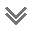

In [5]:
soup